In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

In [21]:
dataset_path = "Multi-class Weather Dataset"
image_size = (180, 180)
batch_size = 32
seed = 1337

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
num_classes = len(class_names)

# prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 1083 files belonging to 4 classes.
Using 867 files for training.
Using 216 files for validation.


In [22]:
# baseline CNN model
def build_baseline_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_model = build_baseline_model(image_size + (3,), num_classes)
baseline_model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

baseline_history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.5917 - loss: 2.1460 - val_accuracy: 0.8102 - val_loss: 0.7344
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.8281 - loss: 0.4718 - val_accuracy: 0.8565 - val_loss: 0.6070
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.8870 - loss: 0.2907 - val_accuracy: 0.7917 - val_loss: 0.6582
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.9043 - loss: 0.2613 - val_accuracy: 0.8981 - val_loss: 0.3750
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.9573 - loss: 0.1388 - val_accuracy: 0.8935 - val_loss: 0.5064
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9596 - loss: 0.1079 - val_accuracy: 0.9120 - val_loss: 0.4790
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.9712 - loss: 0.0975 - val_accuracy: 0.9213 - val_loss: 0.4837
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.9850 - loss: 0.0490 - val_accuracy: 0.9306 - val_

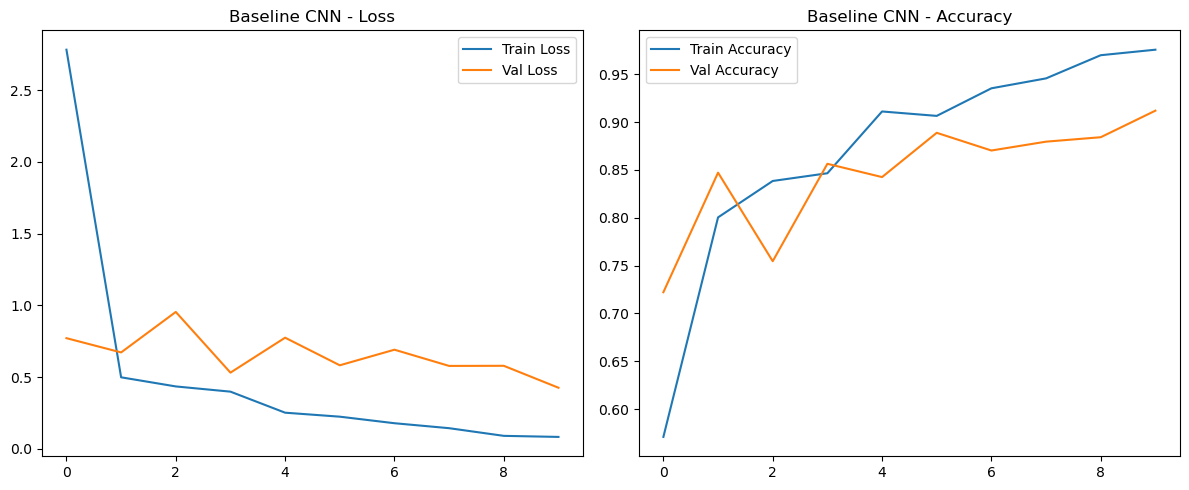

In [13]:
# learning curve
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.legend()
    plt.title(f"{title} - Accuracy")

    plt.tight_layout()
    plt.show()

plot_learning_curves(baseline_history, "Baseline CNN")

In [14]:
# transfer learning
base_model = keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

transfer_model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=image_size + (3,)),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation="softmax")
])

transfer_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

transfer_history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10


/var/folders/j0/q4ftkx0907b9x11x30hmvp240000gn/T/ipykernel_33097/3783993556.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.4129 - loss: 1.4129 - val_accuracy: 0.5463 - val_loss: 0.9974
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6182 - loss: 0.9285 - val_accuracy: 0.7083 - val_loss: 0.7318
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.7047 - loss: 0.7313 - val_accuracy: 0.7870 - val_loss: 0.5906
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7705 - loss: 0.6047 - val_accuracy: 0.8287 - val_loss: 0.5062
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.8097 - loss: 0.5180 - val_accuracy: 0.8704 - val_loss: 0.4342
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.8304 - loss: 0.4845 - val_accuracy: 0.8843 - val_loss: 0.3934
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.8708 - loss: 0.4016 - val_accuracy: 0.8981 - val_loss: 0.3603
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8720 - loss: 0.3699 - val_accuracy: 0.9028 - val_

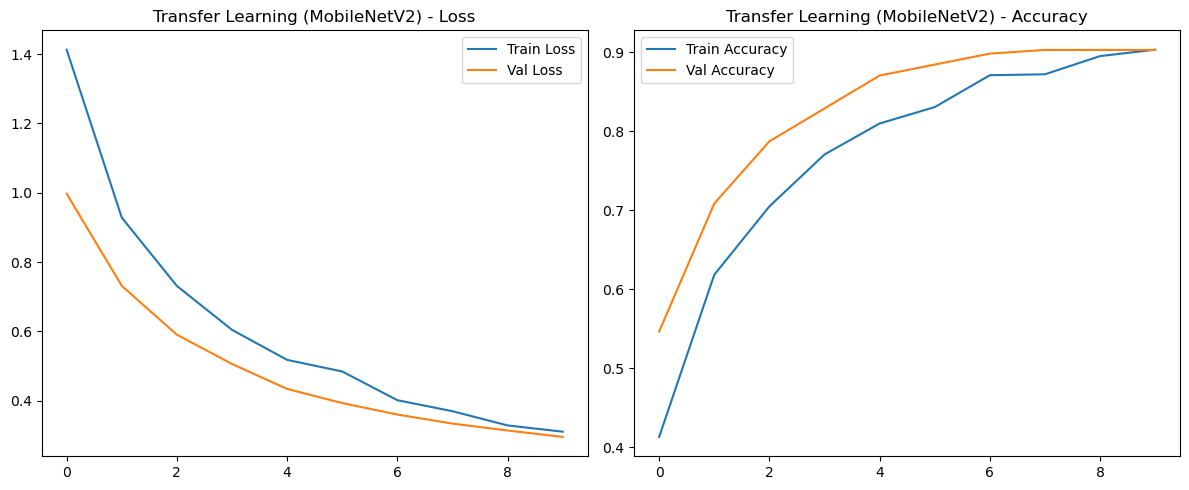

In [15]:
# learning curve for the transfer learning

plot_learning_curves(transfer_history, "Transfer Learning (MobileNetV2)")

In [16]:
# making sure to save the trained model
transfer_model.save("TransferWeatherModel.keras")

In [17]:
#classification report based off of validation set
# Predict on val_ds
y_true, y_pred = [], []
for images, labels in val_ds:
    preds = transfer_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.90      0.90      0.90        62
        Rain       0.95      0.97      0.96        40
       Shine       0.89      0.77      0.82        52
     Sunrise       0.88      0.97      0.92        62

    accuracy                           0.90       216
   macro avg       0.91      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216



2025-08-04 15:19:13.620576: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The classification report indicates that the model performs very well overall, achieving 90% accuracy on the validation set. The "Rain" class is nearly perfect, with both precision and recall at 97%, showing the model consistently identifies rain images correctly. However, the "Shine" class has the lowest recall at 75%, meaning a portion of those images are being misclassified as other classes, despite a solid precision of 89%. The other classes—"Cloudy" and "Sunrise"—are well-balanced and consistent in performance. These results suggest that the model generalizes effectively and does not appear to suffer from significant class imbalance. Nonetheless, performance could be further improved with targeted strategies such as adding more diverse "Shine" images or applying more specific data augmentation techniques to better capture its distinguishing features.